<img src="../part_of_cover_bakker_post.png" width="800px">

The Python code provided below is from <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392

The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).

This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). 

<p>© 2022 Mark Bakker and Vincent Post</p>

# Transient two-dimensional flow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["contour.negative_linestyle"] = 'solid' # set default line style
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## Wells in confined and unconfined aquifers

In [2]:
# parameters
T = 200 # transmissivity, m^2/d
S = 2E-3 # storage coefficient, -
rw = 0.3 # radius of well, m
Q = 1000 # discharge of well, m^3/d
t0 = 0 # start of pumping, d

In [3]:
# solution
from scipy.special import exp1
def htheis(r, t, T, S, Q, t0=0):
    return -Q / (4 * np.pi * T) * exp1(S * r ** 2 / (4 * T * (t - t0)))

t = np.logspace(-3, 0, 100)
hw = htheis(rw, t, T, S, Q, t0)
h20 = htheis(20, t, T, S, Q, t0)
h20approx = Q / (4 * np.pi * T) * (np.euler_gamma + 
                                   np.log(S * 20 ** 2 / (4 * T * (t - t0))))

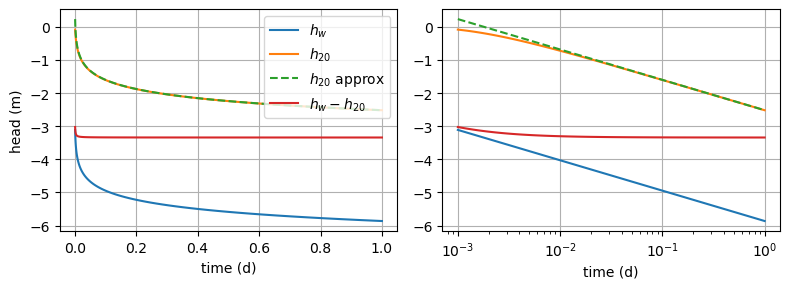

In [4]:
# basic plot
plt.subplot(121)
plt.plot(t, hw, label='$h_w$')
plt.plot(t, h20, label='$h_{20}$')
plt.plot(t, h20approx, '--', label='$h_{20}$ approx')
plt.plot(t, hw - h20, label='$h_w - h_{20}$')
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.grid()
plt.legend()
plt.subplot(122)
plt.semilogx(t, hw)
plt.semilogx(t, h20)
plt.semilogx(t, h20approx, '--')
plt.semilogx(t, hw - h20)
plt.xlabel('time (d)')
plt.grid();

In [5]:
# parameters
t0 = 0 # time pump starts, d
t1 = 1 # time pump is turned off, d
S = [1E-3, 1E-4] # storage coefficients, -
r = 100 # m

In [6]:
# solution
t = np.linspace(1e-6, 2, 200)
h = np.zeros((2, len(t)))
for i in range(2):
    h[i] = -Q / (4 * np.pi * T) * exp1(S[i] * r ** 2 / (4 * T * (t - t0)))
    h[i, t > t1] -= -Q / (4 * np.pi * T) * exp1(
        S[i] * r ** 2 / (4 * T * (t[t > t1] - t1)))
tapprox = np.linspace(t1 + 0.01, 2, 100)
happrox = Q / (4 * np.pi * T) * np.log((tapprox - t1) / (tapprox - t0))

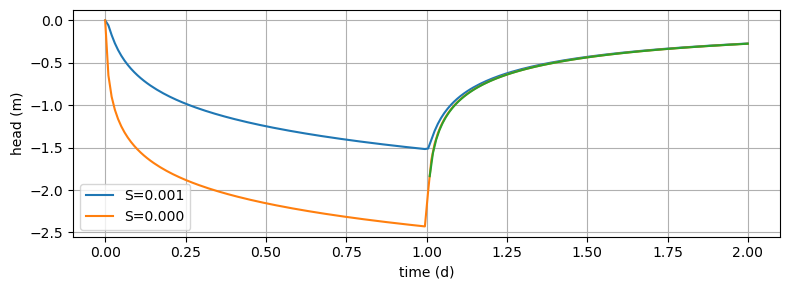

In [7]:
# basic plot
plt.plot(t, h[0], label=f'S={S[0]:.3f}')
plt.plot(t, h[1], label=f'S={S[1]:.3f}')
plt.plot(tapprox, happrox)
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();

In [8]:
# Data at Oude Korendijk taken from Kruseman and de Ridder (1990)
robs = 30 # distance to of observation well, m
Q = 788 # discharge of well, m^3/d
time = np.array(
    [0.1 ,  0.25,  0.5 ,  0.7 ,  1.  ,  1.4 ,  1.9 ,  2.33,  2.8 ,
     3.36,  4.  ,  5.35,  6.8 ,  8.3 ,  8.7 , 10.  , 13.1 , 18.  ,
     27. ,  33. ,  41. ,  48. ,  59. ,  80. , 95.  , 139. , 181. , 
     245.,  300.,  360.,  480.,  600.,  728., 830.]) # in minutes
drawdown = np.array(
    [0.04 , 0.08 , 0.13 , 0.18 , 0.23 , 0.28 , 0.33 , 0.36 , 0.39 ,
     0.42 , 0.45 , 0.5  , 0.54 , 0.57 , 0.58 , 0.6  , 0.64 , 0.68 ,
     0.742, 0.753, 0.779, 0.793, 0.819, 0.855, 0.873, 0.915, 0.935,
     0.966, 0.99 , 1.007, 1.05 , 1.053, 1.072, 1.088]) # in meters
tobs = time / 24 / 60 # convert observation time to days
hobs = -drawdown # convert drawdown to heads

In [9]:
def fobj(p, ho, to, ro, Q, return_heads=False):
    T, S = p
    hm = htheis(ro, to, T, S, Q)
    if return_heads:
        return hm
    rv = np.sum((ho - hm) ** 2)
    return rv

In [10]:
# least squares solution
from scipy.optimize import fmin
T, S = fmin(fobj, [100, 1e-4], args=(hobs, tobs, robs, Q), disp=0)
print(f'Estimated parameters T: {T:.2f} m^2/d, S: {S:.2e}')
hm = fobj([T, S], hobs, tobs, robs, Q, return_heads=1) # compute modeled heads
rmse = np.sqrt(np.mean((hobs - hm) ** 2))
print(f'Root mean squared error: {rmse:.3f} m')

Estimated parameters T: 480.47 m^2/d, S: 1.13e-04
Root mean squared error: 0.032 m


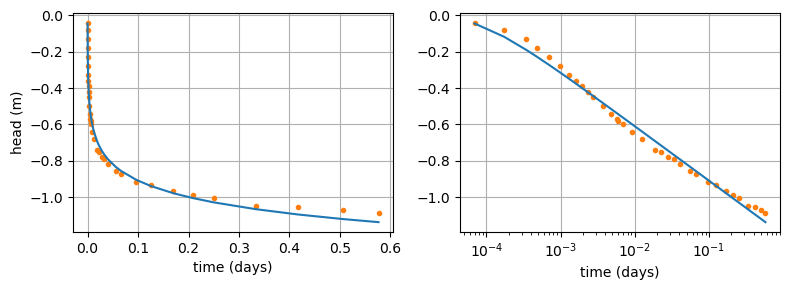

In [11]:
# basic plot
plt.subplot(121)
plt.plot(tobs, hobs, 'C1.')
plt.plot(tobs, hm, 'C0')
plt.xlabel('time (days)')
plt.ylabel('head (m)')
plt.grid()
plt.subplot(122)
plt.semilogx(tobs, hobs, 'C1.')
plt.semilogx(tobs, hm, 'C0')
plt.xlabel('time (days)')
plt.grid();

## A well with a periodic discharge

In [12]:
# parameters
T = 100 # transmissivity, m^2/d
S = 1e-1 # storage coefficient, -
tau = 365 # period, d
A = 200 # amplitude of discharge function, m^3/d
rw = 0.3 # radius of well, m
mu = np.sqrt(T * tau / (S * 2 * np.pi))
print(f'characteristic length mu: {mu:.2f} m')

characteristic length mu: 241.02 m


In [13]:
# solution
from scipy.special import kv
def hsinwell(r, t):
    hcomplex = -A / (2 * np.pi * T) * kv(0, r * np.sqrt(1j) / mu) * \
               np.exp(2 * np.pi * 1j * t / tau)
    return hcomplex.imag

def Qrsinwell(r, t):
    Qrcomplex = -A / (2 * np.pi) * np.sqrt(1j) / mu * \
                kv(1, r * np.sqrt(1j) / mu) * np.exp(2 * np.pi * 1j * t / tau)
    return Qrcomplex.imag

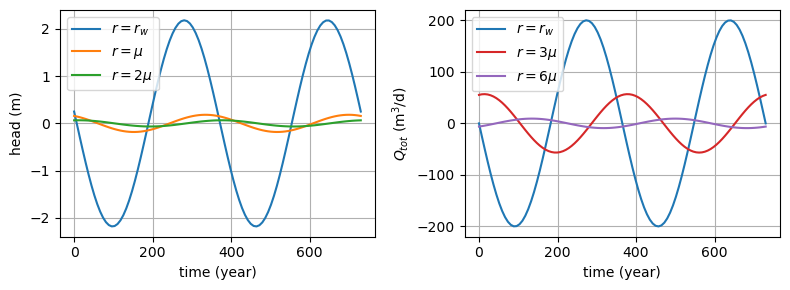

In [14]:
# basic plot
t = np.linspace(0, 2 * tau, 100)
plt.subplot(121)
plt.plot(t, hsinwell(rw, t), label='$r=r_w$')
plt.plot(t, hsinwell(mu, t), label='$r=\mu$')
plt.plot(t, hsinwell(2 * mu, t), label='$r=2\mu$')
plt.xlabel('time (year)')
plt.ylabel('head (m)')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(t, Qrsinwell(rw, t) * 2 * np.pi * rw, label='$r=r_w$')
plt.plot(t, Qrsinwell(3 * mu, t) * 2 * np.pi * 3 * mu, 'C3', label='$r=3\mu$')
plt.plot(t, Qrsinwell(6 * mu, t) * 2 * np.pi * 6 * mu, 'C4', label='$r=6\mu$')
plt.xlabel('time (year)')
plt.ylabel('$Q_{tot}$ (m$^3$/d)')
plt.legend()
plt.grid();

## Wells in a semi-confined aquifer

In [15]:
# parameters
T = 200 # transmissivity of aquifer, m^2/d
S = 0.0005 # storage coefficient of aquifer, -
c = 1000 # resistance of leaky layer, d
Q = 800 # discharge of well, m^3/d
rw = 0.3 # radius of well, m
lab = np.sqrt(c * T) # leakage factor, m
print(f'leakage factor: {lab:.2f} m')

leakage factor: 447.21 m


In [16]:
# solution
from scipy.integrate import quad

def integrand(tau, r, T, lab):
    return 1 / tau * np.exp(-tau - r ** 2 / (4 * lab ** 2 * tau))

def hantush(r, t, T, S, c, Q):
    lab = np.sqrt(T * c)
    u = S * r ** 2 / (4 * T * t)
    F = quad(integrand, u, np.inf, args=(r, T, lab))[0]
    return -Q / (4 * np.pi * T) * F

hantushvec = np.vectorize(hantush) # vectorized version of hantush function

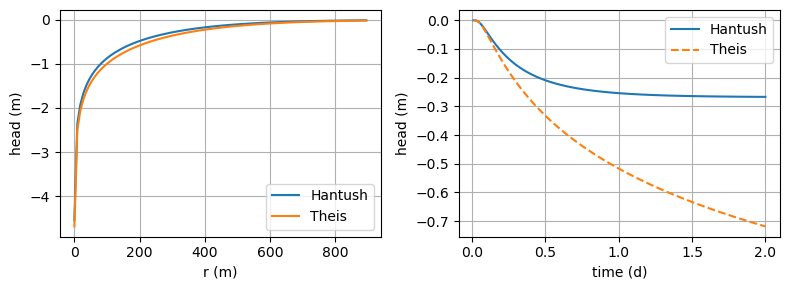

In [17]:
# basic plot for one value of r and one value of t
plt.subplot(121)
r = np.linspace(rw, 2 * lab, 100)
t = 6 / 24
plt.plot(r, hantushvec(r, t, T, S, c, Q), label='Hantush')
plt.plot(r, htheis(r, t, T, S, Q), label='Theis') # theis func from Section 9.1
plt.xlabel('r (m)')
plt.ylabel('head (m)')
plt.legend()
plt.grid()
plt.subplot(122)
t = np.linspace(0.01, 2, 100)
r = lab # evaluate head at r=lambda
plt.plot(t, hantushvec(r, t, T, S, c, Q), label='Hantush')
plt.plot(t, htheis(r, t, T, S, Q), '--', label='Theis')
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();

In [18]:
from scipy.special import factorial as fac
def stehfest_coef(M): # from Chapter 5
    assert M % 2 == 0, 'M must be even'
    M2 = int(M / 2)
    V = np.zeros(M)
    for k in range(1, M + 1):
        z = np.zeros(min(k, M2) + 1)
        for j in range(int((k + 1) / 2), min(k, M2) + 1):
            z[j] = j ** M2 * fac(2 * j) / \
            (fac(M2 - j) * fac(j) * fac(j - 1) * fac(k - j) * fac(2 * j - k))
        V[k - 1] = (-1) ** (k + M2) * np.sum(z)
    return V

In [19]:
def stehfest(x, t, func, M=12, **kwargs): # from Chapter 5
    t = np.atleast_1d(t)
    x = np.atleast_1d(x)
    f = np.zeros((len(x), len(t)))
    V = stehfest_coef(M)
    for i in range(len(t)):
        p = np.arange(1, M + 1) * np.log(2) / t[i]
        for j in range(len(x)):
            fbar = func(p, x[j], **kwargs)
            f[j, i] = np.log(2) / t[i] * np.sum(V * fbar)
    return f

In [20]:
# Laplace transform solution
from scipy.special import k0
def hbar(p, r, T, S, c, Q):
    w = (S * c * p + 1) / (c * T)
    return -Q / (2 * np.pi * T * p) * k0(r * np.sqrt(w))

t = np.linspace(1e-3, 1, 100)
h = stehfest(250, t, hbar, T=T, S=S, c=c, Q=Q) # stehfest func from Section 5.5
h_hantush = hantushvec(250, t, T, S, c, Q)

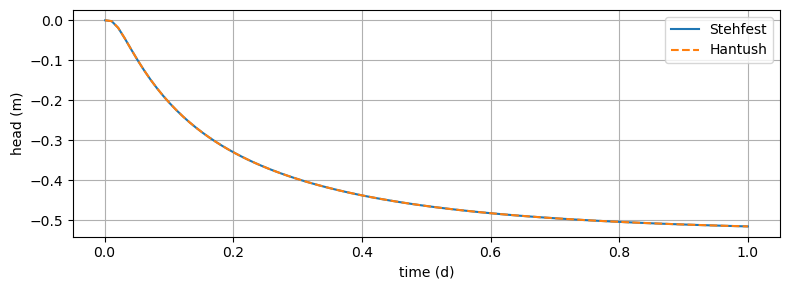

In [21]:
# basic plot
plt.plot(t, h[0], label='Stehfest')
plt.plot(t, h_hantush, '--', label='Hantush')
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();

## Wells with wellbore storage and skin effect

<img src="figs/fig9.1.png" width=400>

In [22]:
# parameters
T = 200 # transmissivity, m^2/d
S = 0.005 # storage coefficient of aquifer, -
H = 10 # aquifer thickness, m
Q = 800 # discharge of well, m^3/d
rw = 0.3 # well radius, m
cw = 0.02 # resistance of well screen, d

In [23]:
# solution
from scipy.special import k0, k1
def hbar_wbs_res(p, r, T, S, Q, rw, cw, H): # hbar
    sqrtw = np.sqrt(S * p / T)
    Aw = np.pi * rw ** 2
    B = -Q / p * 1 / (p * Aw * k0(rw * sqrtw) + 
                     (2 * np.pi * rw + Aw * p * cw / H) * 
                      T * sqrtw * k1(rw * sqrtw))
    hbar = B * k0(r * sqrtw)
    return hbar

def Qrbar_wbs_res(p, r, T, S, Q, rw, cw, H): # Qrbar
    sqrtw = np.sqrt(S * p / T)
    Aw = np.pi * rw ** 2
    B = -Q / p * 1 / (p * Aw * k0(rw * sqrtw) + 
                     (2 * np.pi * rw + Aw * p * cw / H) * 
                      T * sqrtw * k1(rw * sqrtw))
    Qrbar = T * sqrtw * B * k1(r * sqrtw)
    return Qrbar

def hwbar_wbs_res(p, r, T, S, Q, rw, cw, H): # hbar inside well
    # r is not used, but Stehfest routine requires it
    hrw = hbar_wbs_res(p, rw, T, S, Q, rw, cw, H)
    Qrw = Qrbar_wbs_res(p, rw, T, S, Q, rw, cw, H)
    return cw * Qrw / H + hrw

# import stehfest_coef and stehfest from Section 5.4
t = np.logspace(-3, 0, 100)
ht = htheis(rw, t, T, S, Q) # function from Section 9.1
hw = stehfest(0, t, hwbar_wbs_res, T=T, S=S, Q=Q, rw=rw, cw=cw, H=H)
hwbs = stehfest(rw, t, hbar_wbs_res, T=T, S=S, Q=Q, rw=rw, cw=0, H=H)
hwbsres = stehfest(rw, t, hbar_wbs_res, T=T, S=S, Q=Q, rw=rw, cw=cw, H=H)

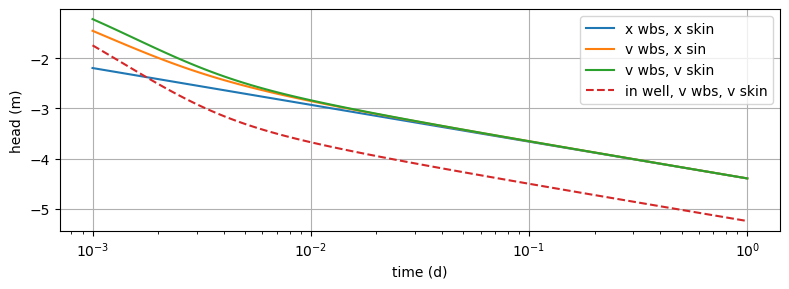

In [24]:
# plot of head at well
plt.semilogx(t, ht, label='x wbs, x skin')
plt.semilogx(t, hwbs[0], label=f'v wbs, x sin')
plt.semilogx(t, hwbsres[0], label=f'v wbs, v skin')
plt.semilogx(t, hw[0], '--', label=f'in well, v wbs, v skin')
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();

## Wells in a two-aquifer system

In [25]:
# parameters
T0 = 100 # transmissivity top aquifer, m^2/d
S0 = 0.1 # specific yield top aquifer, -
T1 = 200 # transmissivity bottom aquifer, m^2/d
S1 = 0.001 # storage coefficient bottom aquifer, -
c = 500 # resistance of leaky layer, d
Q = 800 # discharge of well, m^3/d
rw = 0.3 # radius of well, m

In [26]:
# solution
from scipy.special import k0
def hmaqbar(plist, r, layer):
    hbar = np.zeros(len(plist))
    for i, p in enumerate(plist):
        A = np.array([[(p * c * S0 + 1) / (c * T0), -1 / (c * T0)],
                      [-1 / (c * T1), (p * c * S1 + 1) / (c * T1)]])
        w, v = np.linalg.eig(A)
        b = np.linalg.solve(v, [0, 1])
        hbar[i] = -Q / (2 * np.pi * T1 * p) * (
            b[0] * v[layer, 0] * k0(r * np.sqrt(w[0])) + 
            b[1] * v[layer, 1] * k0(r * np.sqrt(w[1])))
    return hbar

r = 250
t = np.logspace(-3, 2, 100)
h0 = stehfest(r, t, hmaqbar, layer=0) # stehfest function from Section 5.5
h1 = stehfest(r, t, hmaqbar, layer=1)
h1_hantush = hantushvec(r, t, T1, S1, c, Q) # hantushvec from Section 9.3

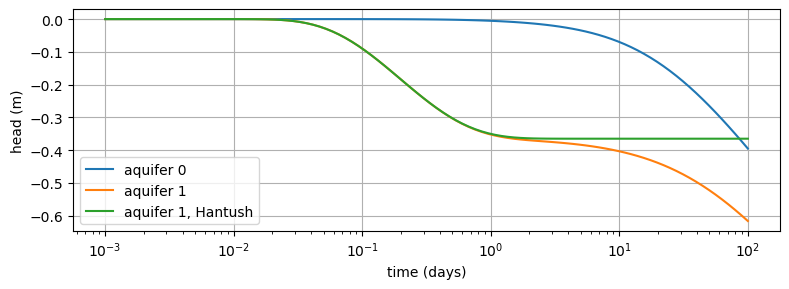

In [27]:
# basic plot semilog
plt.semilogx(t, h0[0], label='aquifer 0')
plt.semilogx(t, h1[0], label='aquifer 1')
plt.semilogx(t, h1_hantush, label='aquifer 1, Hantush')
plt.xlabel('time (days)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();